In [235]:
import import_ipynb
from BankFindSearch import search

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd

In [236]:
#designate variables of interest 
#only difference from other models is that numeric_cols excludes OFFICES
#this is because OFFICES data is missing for inactive banks
numeric_cols = ['ASSET', 'DEP', 'EQ']
flag_cols = ['ACTIVE', 'CB', 'CHRTAGNT',  'CFPBFLAG', 'FEDCHRTR',
            'FORM31', 'HCTMULT', 'IBA', 'INSCOML', 'INSSAVE', 'MDI_STATUS_DESC', 'REGAGNT', 'SPECGRP',  'STCHRTR', 'SUBCHAPS',
            'TRACT', 'TRUST']
cols = numeric_cols + flag_cols
variables = flag_cols + ['ROA']

# Model 3
##### This model will consider all banks (active/inactive) and will only use categorical variables (```flag_cols```)

In [237]:
#search for ALL institutions (active or inactive)
r = search("institutions", '', variables)

In [238]:
#load data into pandas dataframe
frame = pd.DataFrame(r, columns = variables)

In [239]:
#drop missing values
data = frame.dropna()

In [240]:
#clean data - convert to binary indicators and convert strings to ints
cdata = data.drop('SPECGRP', axis = 1)
cdata['CHRTAGNT'] = data['CHRTAGNT'].map(dict(STATE=1, OCC=0))
cdata['MDI_STATUS_DESC'] = data['MDI_STATUS_DESC'].map(lambda x: 0 if x == "NONE" else 1)
cdata['REGAGNT'] = data['REGAGNT'].map(lambda x: 0 if x == "FDIC" else 1)
cdata['COMLS'] = data['SPECGRP'].map(lambda x: 1 if x == 4 else 0)
cdata['AGRS'] = data['SPECGRP'].map(lambda x: 1 if x == 2 else 0)
cdata['CONLS'] = data['SPECGRP'].map(lambda x: 1 if x == 6 else 0)
cdata['CCS'] = data['SPECGRP'].map(lambda x: 1 if x == 3 else 0)
cdata['INTLS'] = data['SPECGRP'].map(lambda x: 1 if x == 1 else 0)
cdata['MRLS'] = data['SPECGRP'].map(lambda x: 1 if x == 5 else 0)
cdata['OOBS'] = data['SPECGRP'].map(lambda x: 1 if x == 9 else 0)
cdata['CB'] = data['CB'].map(lambda x: 1 if x == '1' else 0)
cdata['FORM31'] = data['FORM31'].map(lambda x: 1 if x == '1' else 0)
cdata['HCTMULT'] = data['HCTMULT'].map(lambda x: 1 if x == '1' else 0)
cdata['TRACT'] = data['TRACT'].map(lambda x: 1 if x == '1' else 0)
cdata['TRUST'] = data['TRUST'].map(lambda x: 1 if x == '1' else 0)
cdata['SUBCHAPS'] = data['SUBCHAPS'].map(lambda x: 1 if x == '1' else 0)

In [241]:
#shuffle data - preparing for split
cdata_shuff =  cdata.sample(frac=1, random_state=45)

#add new col for binary indicator or ROA (1 if ROA is positive, 0  otherwise)
#note that this is different than Models 1 and 2
#>0% and >1% both give about 70-30 split, so seems most logical to use >0 and balance
cdata_shuff['ROAb'] = [0 if x < 0 else 1 for x in cdata_shuff['ROA']]
cdata_shuff2 = cdata_shuff.drop('ROA', axis = 1)

In [242]:
#check to see if data is balanced
sum(cdata_shuff2['ROAb']) / len(cdata_shuff2['ROAb'])

0.7280598520511096

In [243]:
#Balance the dataset to have an equal amount of 0 and 1 targets
num_zero_targets = len(cdata_shuff2['ROAb']) - sum(cdata_shuff2['ROAb'])
one_targets_counter = 0
indices = []

count = 0
for index,row in cdata_shuff2.iterrows():
    if (row['ROAb'] == 1):
        one_targets_counter += 1
        if one_targets_counter > num_zero_targets:
            indices.append(index)

data_balanced = cdata_shuff2.drop(indices)

In [244]:
#check to make sure we are now balanced
sum(data_balanced['ROAb']) / len(data_balanced['ROAb'])

0.5

In [245]:
#shuffle to disperse evenly the balanced 1s and 0s
data_balanced_shuff = data_balanced.sample(frac=1, random_state=37)

In [246]:
#partition inputs and targets
targets = list(data_balanced_shuff['ROAb'])
inputs = data_balanced_shuff.drop('ROAb', axis = 1)

In [247]:
#split into test and train datasets
train, test = train_test_split(inputs, test_size=0.10, shuffle=False)

train_targets = targets[:len(train)]
test_targets = targets[len(train):]

In [248]:
#load xgb matrix
dtrain = xgb.DMatrix(train, label=train_targets)
dtest = xgb.DMatrix(test, label=test_targets)

In [249]:
#train the model
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 8
bst = xgb.train(param, dtrain, num_round)

[13:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [250]:
#generate predictions
preds = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

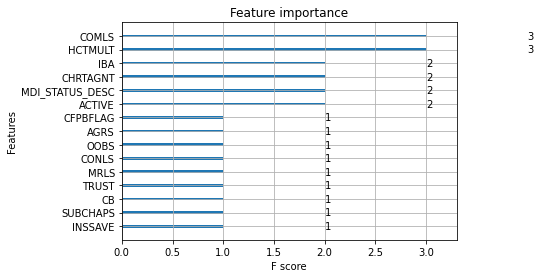

In [251]:
#plot feature importance
xgb.plot_importance(bst)

In [252]:
#calculate train and test accuracy
test_count = 0

for i in range(len(test)):
    if preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == test_targets[i]:
        test_count+=1
        
train_preds = bst.predict(dtrain)
train_count = 0
for i in range(len(train)):
    if train_preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == train_targets[i]:
        train_count+=1
        
print(f'Train accuracy: {train_count / len(train)}\nTest accuracy: {test_count/ len(test)}')

Train accuracy: 0.7129486518976472
Test accuracy: 0.7194744976816074


### Summary
#### This model considered both active and inactive banks
#### This model considered only categorical variables
#### Model Accuracy = 72%
##### This model has the best accuracy so far, which is promising. It can hopefully prove useful in giving a generic overview of which structural variables are most impactful towards a positive return on assets.

# Model 4

##### This model will consider all banks (active/inactive) and will use both the categorical/binary indicator variables and the quantitative variables(```flag_cols``` and ```numeric_cols```)

In [253]:
#load numeric data from API
num_r = search("institutions", '', numeric_cols)

In [254]:
#load data into pandas
new_frame = pd.DataFrame(num_r, columns = numeric_cols)

#drop missing values
num_frame = new_frame.dropna()
new_data= num_frame.copy()

#cast numeric variables from string to floats
new_data['ASSET'] = pd.to_numeric(num_frame['ASSET'], downcast = "float")
new_data['DEP'] = pd.to_numeric(num_frame['DEP'], downcast = "float")
new_data['EQ'] = pd.to_numeric(num_frame['EQ'], downcast = "float")

In [255]:
#scale the quantitative data
scaler = preprocessing.StandardScaler()
scaled_num_data = scaler.fit_transform(new_data)
scaled_num_data = pd.DataFrame(scaled_num_data, columns=numeric_cols)

In [256]:
#combine the scaled numeric data with the categorical data from Model 3
join_data = scaled_num_data.join(cdata)

In [257]:
#remove missing values - once again, these arise from casting some numeric variables
new_cdata = join_data.dropna()

In [258]:
#shuffle data - preparing for split
new_cdata_shuff =  new_cdata.sample(frac=1, random_state=7)

#add new col for binary indicator or ROA (1 if ROA is positive, 0  otherwise)
#note that this is different than Models 1 and 2
#>0% and >1% both give about 70-30 split, so seems most logical to use >0 and balance
new_cdata_shuff['ROAb'] = [0 if x < 0 else 1 for x in new_cdata_shuff['ROA']]
new_cdata_shuff2 = new_cdata_shuff.drop('ROA', axis = 1)

In [259]:
#check to see if data is balanced
sum(new_cdata_shuff2['ROAb']) / len(new_cdata_shuff2['ROAb'])

0.7566459902525476

In [260]:
#Balance the dataset to have an equal amount of 0 and 1 targets
num_zero_targets = len(new_cdata_shuff2['ROAb']) - sum(new_cdata_shuff2['ROAb'])
one_targets_counter = 0
indices = []

count = 0
for index,row in new_cdata_shuff2.iterrows():
    if (row['ROAb'] == 1):
        one_targets_counter += 1
        if one_targets_counter > num_zero_targets:
            indices.append(index)

new_data_balanced = new_cdata_shuff2.drop(indices)

In [261]:
#check to make sure we are now balanced
sum(new_data_balanced['ROAb']) / len(new_data_balanced['ROAb'])

0.5

In [262]:
#shuffle to disperse evenly the balanced 1s and 0s
new_data_balanced_shuff = new_data_balanced.sample(frac=1, random_state=8)

In [263]:
#partition inputs and targets
new_targets = list(new_data_balanced_shuff['ROAb'])
new_inputs = new_data_balanced_shuff.drop('ROAb', axis = 1)

In [264]:
#split into test and train datasets
new_train, new_test = train, test = train_test_split(new_inputs, test_size=0.10, shuffle=False)

new_train_targets = new_targets[:len(new_train)]
new_test_targets = new_targets[len(new_train):]

In [265]:
#load into xgb matrix
new_dtrain = xgb.DMatrix(new_train, label=new_train_targets)
new_dtest = xgb.DMatrix(new_test, label=new_test_targets)

In [266]:
#execute xgb train
param = {'max_depth': 2, 'eta':1, 'objective':'binary:logistic' }
num_round = 8
new_bst = xgb.train(param, new_dtrain, num_round)

[13:59:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [267]:
#generate predictions on test
new_preds = new_bst.predict(new_dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

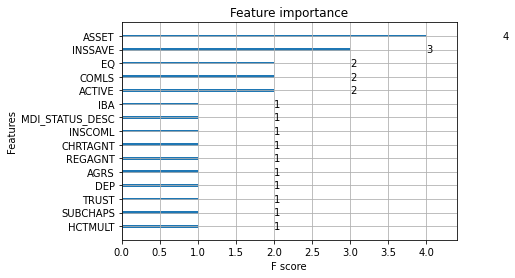

In [268]:
#plot feauture importance
xgb.plot_importance(new_bst)

In [269]:
#print test and train accuracy
test_count = 0
for i in range(len(new_test)):
    if new_preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == new_test_targets[i]:
        test_count+=1
        
new_train_preds = new_bst.predict(new_dtrain)
train_count = 0
for i in range(len(new_train)):
    if new_train_preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == new_train_targets[i]:
        train_count+=1
        
print(f'Train accuracy: {train_count / len(new_train)}\nTest accuracy: {test_count/ len(new_test)}')

Train accuracy: 0.7017322038184347
Test accuracy: 0.689419795221843


### Summary
#### This model considered both active and inactive banks
#### This model considered both quantitative and categorical variables
#### Model Accuracy = 69%
##### This model has a dissapointing accuracy, and its lower test accuracy indicates that our model may have overfit a tad. While it is somewhat suprising this model did not perform better, the three extra variables introduced did create some missing value and balancing problems, which led to having a smaller dataset to work with overall compared with Model 3.